In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict
import os


In [2]:
filename = "saves/spsa/medium20/12000_1698602611_results.pkl"
os.path.dirname(filename)


'saves/spsa/medium20'

In [3]:
def show_weights(filename):
    vals = {}
    actions = 'up right down left'.split()
    with open(filename, 'rb') as file:
        state_dict = torch.load(file)
    for key, value in state_dict.items():
        # vals[key+".max"] = value.max().item()
        # vals[key+".min"] = value.min().item()
        for act, row in zip(actions, value.numpy().round(2)):
            vals[f"{key}.{act}"] = row
    return vals

def get_results(filename):
    with open(filename, "rb") as file:
        results = pickle.load(file)
    dirname = os.path.dirname(filename)
    rolled_up = []
    frame = []
    for seed, result in enumerate(results):
        r = pd.Series(result).rolling(200, min_periods=1).mean().dropna()
        r = list(r)
        rolled_up.append(r)
        weights_file = os.path.join(dirname, f"weights.{seed}.pth")
        vals = show_weights(weights_file)
        vals["perf"] = r[-1]
        frame.append(vals)
    frame = pd.DataFrame.from_records(frame)
    display(frame.sort_values("perf", ascending=False))
    rolled_up = np.array(rolled_up)

    avg_rewards = np.median(rolled_up, 0)
    min_rewards = rolled_up.min(0)
    max_rewards = rolled_up.max(0)
    std_rewards = rolled_up.std(0)

    bot = np.maximum(avg_rewards - std_rewards, min_rewards)
    top = np.minimum(avg_rewards + std_rewards, max_rewards)
    return avg_rewards, bot, top


In [4]:
vals = defaultdict(int)
for seed in range(10):
    # print(seed)
    with open(f"saves/reinforce/tiny/weights.{seed}.pth", 'rb') as file:
        state_dict = torch.load(file)
    for key, value in state_dict.items():
        # print("\t", key, value.max(), value.min())
        vals[key+".max"] = max(vals[key+".max"], value.max().item())
        vals[key+".min"] = min(vals[key+".min"], value.min().item())

print("Reinforce")
for key, value in vals.items():
    print(key, value)


Reinforce
fc.weight.max 0.5456724762916565
fc.weight.min -0.8427281379699707
fc.bias.max 0.8449665904045105
fc.bias.min -0.7622199058532715


In [5]:
vals = defaultdict(int)
for seed in range(10):
    # print(seed)
    with open(f"saves/spsa/tiny/weights.{seed}.pth", 'rb') as file:
        state_dict = torch.load(file)
    for key, value in state_dict.items():
        vals[key+".max"] = max(vals[key+".max"], value.max().item())
        vals[key+".min"] = min(vals[key+".min"], value.min().item())

print("SPSA")
for key, value in vals.items():
    print(key, value)


SPSA
fc.weight.max 0.5448506474494934
fc.weight.min -0.5521352291107178
fc.bias.max 0.44599175453186035
fc.bias.min -0.47158095240592957


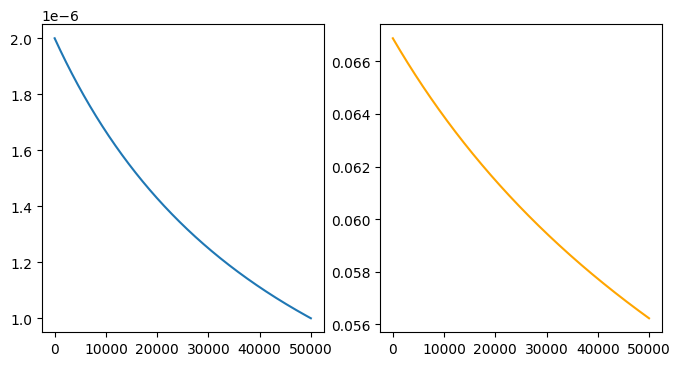

In [6]:
def get_delta(episode):
    return (2e-5 / (1 + episode * 2e-5)) ** 0.25


def get_alpha(episode):
    return 2e-6 / (1 + episode * 2e-5)


episode = np.arange(50000)
alpha = get_alpha(episode)
delta = get_delta(episode)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(episode, alpha)
ax[1].plot(episode, delta, color="orange")


spsa tiny


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[-0.12, 0.21, -0.4, -0.25, -0.07, -0.12]","[0.17, 0.45, -0.08, 0.07, -0.1, 0.11]","[-0.3, -0.28, -0.11, 0.17, 0.23, 0.4]","[-0.37, -0.34, 0.14, 0.16, -0.08, 0.16]",-0.16,0.05,0.37,-0.47,13.469798
1,"[0.2, -0.31, -0.14, -0.01, -0.36, 0.05]","[-0.06, 0.4, 0.13, -0.14, 0.02, 0.15]","[0.28, -0.11, 0.12, 0.14, 0.07, 0.18]","[0.34, 0.18, -0.11, -0.16, -0.14, -0.22]",-0.23,0.03,0.35,0.18,13.415948
2,"[0.04, -0.12, 0.01, -0.25, 0.14, -0.05]","[0.13, -0.09, 0.18, -0.14, 0.1, 0.33]","[-0.1, 0.43, 0.1, 0.44, 0.22, -0.16]","[-0.24, 0.21, -0.47, -0.2, -0.06, -0.07]",-0.02,0.15,-0.10,-0.32,13.303138
8,"[0.07, 0.17, 0.38, -0.22, 0.01, -0.21]","[0.31, -0.38, 0.04, -0.29, 0.43, 0.38]","[-0.15, -0.23, -0.3, 0.54, 0.32, -0.01]","[0.01, -0.24, -0.4, -0.14, -0.38, -0.08]",0.12,-0.27,0.01,-0.09,13.237013
4,"[0.09, -0.09, -0.3, -0.22, -0.41, -0.51]","[0.46, 0.38, 0.09, 0.23, -0.16, -0.19]","[0.34, -0.02, 0.1, 0.36, 0.27, -0.11]","[-0.16, -0.42, 0.07, -0.16, -0.04, -0.1]",0.31,-0.05,0.25,0.18,13.192780
3,"[-0.41, -0.34, -0.22, -0.55, -0.03, -0.42]","[0.15, 0.22, 0.14, -0.01, -0.14, 0.21]","[-0.27, -0.23, -0.34, 0.21, -0.28, 0.48]","[0.35, 0.18, 0.03, -0.25, 0.37, -0.46]",-0.22,-0.27,-0.14,0.05,13.190864
5,"[0.22, -0.35, 0.31, 0.26, 0.25, -0.5]","[-0.16, 0.28, -0.5, 0.31, 0.09, 0.41]","[-0.26, 0.07, 0.26, 0.31, 0.41, 0.28]","[-0.47, 0.3, 0.12, -0.11, -0.3, -0.08]",0.27,-0.35,0.10,0.13,13.166023
6,"[-0.05, 0.01, 0.42, -0.03, -0.35, -0.27]","[0.22, 0.43, 0.08, -0.25, -0.03, 0.16]","[-0.0, 0.09, -0.14, 0.37, 0.39, 0.14]","[-0.08, -0.17, -0.35, -0.26, -0.16, 0.11]",0.13,0.03,-0.16,0.19,13.142362
7,"[-0.04, -0.26, 0.13, -0.01, -0.25, -0.31]","[-0.3, 0.28, -0.12, 0.16, 0.27, 0.04]","[-0.1, -0.18, 0.05, 0.13, 0.24, 0.12]","[0.26, -0.47, 0.22, -0.1, 0.22, -0.1]",0.03,0.06,0.45,0.09,13.120663
9,"[-0.03, -0.35, -0.09, 0.14, 0.4, -0.07]","[-0.16, 0.48, -0.02, -0.11, 0.35, 0.16]","[-0.08, -0.11, 0.12, 0.16, 0.07, 0.28]","[-0.15, 0.06, 0.18, 0.16, 0.41, -0.06]",-0.14,-0.28,0.44,0.12,13.053609


reinforce tiny


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[-0.35, -0.06, -0.5, -0.46, -0.38, -0.24]","[0.13, 0.49, -0.03, 0.07, -0.08, 0.04]","[-0.31, -0.27, 0.01, 0.18, 0.3, 0.35]","[-0.48, -0.34, -0.08, 0.19, -0.29, 0.08]",-0.45,0.14,0.70,-0.76,14.036901
9,"[-0.27, -0.55, -0.21, 0.09, 0.0, -0.03]","[-0.04, 0.53, -0.0, -0.02, 0.55, 0.21]","[0.04, 0.06, 0.28, 0.24, 0.25, 0.23]","[-0.33, -0.17, -0.19, -0.07, -0.01, -0.14]",-0.55,-0.23,0.84,-0.22,13.951476
8,"[-0.28, -0.07, 0.05, -0.42, -0.35, -0.25]","[0.45, -0.28, 0.15, -0.28, 0.43, 0.27]","[-0.07, -0.16, -0.21, 0.5, 0.44, -0.01]","[-0.24, -0.51, -0.62, -0.29, -0.53, -0.2]",-0.38,-0.05,0.29,-0.50,13.949587
1,"[-0.21, -0.53, -0.45, -0.14, -0.71, -0.21]","[0.01, 0.34, 0.06, -0.08, 0.13, 0.1]","[0.25, -0.13, 0.14, 0.13, 0.23, 0.13]","[0.2, -0.02, -0.27, -0.34, -0.26, -0.34]",-0.65,0.18,0.54,-0.20,13.923175
4,"[-0.21, -0.15, -0.46, -0.37, -0.63, -0.64]","[0.43, 0.39, -0.0, 0.25, -0.18, -0.23]","[0.39, -0.04, 0.23, 0.4, 0.41, -0.16]","[-0.43, -0.64, -0.34, -0.48, -0.28, -0.3]",-0.20,0.15,0.54,-0.32,13.912299
5,"[-0.05, -0.6, 0.1, 0.01, 0.05, -0.66]","[-0.09, 0.42, -0.41, 0.3, 0.18, 0.2]","[-0.36, 0.05, 0.38, 0.28, 0.51, 0.15]","[-0.75, -0.03, -0.32, -0.62, -0.7, -0.19]",-0.17,-0.13,0.39,-0.38,13.911214
2,"[-0.17, -0.28, -0.17, -0.27, -0.11, -0.2]","[0.19, -0.11, 0.29, -0.23, 0.23, 0.28]","[-0.01, 0.41, 0.19, 0.36, 0.3, -0.13]","[-0.52, -0.01, -0.84, -0.46, -0.4, -0.13]",-0.48,0.53,0.09,-0.72,13.870677
6,"[-0.21, -0.17, 0.04, -0.2, -0.53, -0.37]","[0.3, 0.36, 0.2, -0.23, 0.02, 0.13]","[0.08, 0.13, -0.11, 0.38, 0.43, 0.08]","[-0.28, -0.34, -0.6, -0.44, -0.45, 0.06]",-0.55,0.24,0.10,-0.26,13.870494
7,"[-0.3, -0.55, -0.14, -0.13, -0.48, -0.41]","[-0.14, 0.27, -0.2, 0.15, 0.3, 0.11]","[0.08, -0.1, 0.29, 0.22, 0.5, -0.05]","[0.11, -0.56, 0.1, -0.22, -0.09, -0.11]",-0.30,0.07,0.81,-0.32,13.782356
3,"[-0.61, -0.53, -0.28, -0.51, -0.14, -0.55]","[0.26, 0.27, -0.08, 0.08, -0.02, 0.24]","[-0.31, -0.15, -0.17, 0.21, -0.17, 0.39]","[0.13, 0.12, -0.17, -0.48, -0.0, -0.63]",-0.63,-0.23,0.13,-0.31,13.761291


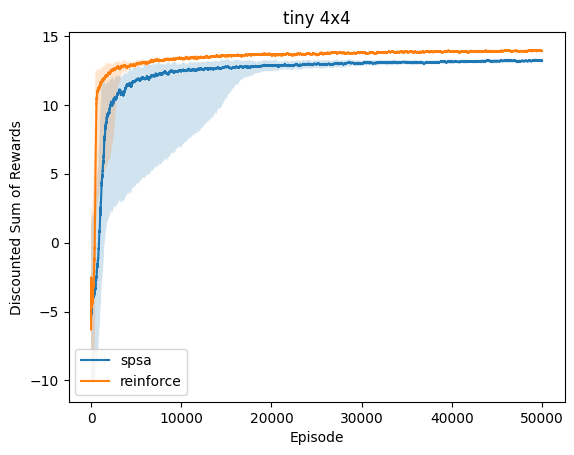

spsa small


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[0.45, -0.36, -0.42, -0.59, 0.01, 0.23]","[-0.46, 1.09, -0.25, -0.46, 0.04, 0.48]","[-0.2, -0.28, -0.25, 0.34, -0.02, 0.85]","[0.2, 0.21, 0.32, -0.02, -0.04, -0.03]",-0.21,0.03,0.53,-0.61,52.202284
4,"[0.13, -0.51, -0.61, 0.03, -0.89, -0.56]","[0.25, 0.5, 0.51, -0.56, -0.19, 0.37]","[0.54, -0.15, 0.12, 0.68, 0.27, -0.09]","[-0.01, -0.09, -0.07, -0.53, 0.28, -0.17]",0.09,0.13,-0.24,-0.23,51.601250
5,"[0.16, -0.46, 0.17, -0.29, -0.05, -0.62]","[-0.41, 0.77, -0.52, -0.11, 0.47, -0.06]","[-0.3, -0.56, 0.42, 0.87, 0.32, 0.02]","[-0.43, 0.1, -0.18, -0.16, -0.13, -0.37]",0.45,0.01,-0.02,-0.36,51.538785
1,"[0.22, -0.11, -0.62, -0.49, -0.12, -0.18]","[0.01, 0.78, -0.06, -0.16, 0.5, 0.52]","[-0.1, -0.36, -0.57, 0.52, 0.35, 0.83]","[0.26, -0.04, -0.36, -0.38, -0.56, -0.27]",-0.32,0.25,0.57,-0.10,51.483188
8,"[0.06, 0.02, 0.49, -0.4, 0.42, 0.0]","[0.58, 0.07, 0.53, -0.5, 0.42, 0.6]","[-0.22, -0.25, -0.5, 1.01, 0.16, -0.04]","[-0.36, -0.18, -0.17, -0.28, -0.26, 0.24]",-0.23,-0.32,0.24,0.45,51.290736
2,"[-0.33, -0.2, -0.06, -0.36, 0.32, 0.27]","[-0.01, 0.26, -0.09, -0.37, 0.19, 0.67]","[-0.11, 0.37, 0.33, 0.75, 0.21, -0.22]","[-0.14, 0.79, -0.07, -0.38, -0.58, -0.58]",0.07,0.11,0.06,-0.13,51.237430
3,"[-0.34, 0.1, -0.54, -1.15, -0.01, -0.68]","[0.02, 0.61, -0.26, -0.18, 0.1, 0.4]","[-0.56, -0.73, -0.46, 0.79, -0.0, 0.7]","[0.29, 0.07, 0.13, -0.89, 0.24, -0.02]",-0.03,-0.28,0.04,0.39,51.127812
6,"[0.21, -0.08, 0.53, -0.52, -0.02, -0.22]","[0.72, 0.74, -0.0, -0.76, -0.17, 0.23]","[0.39, -0.17, -0.31, 0.2, 0.05, 0.32]","[-0.47, -0.05, -0.61, 0.15, 0.55, -0.3]",-0.24,-0.26,0.05,0.06,50.831590
9,"[-0.14, 0.01, -0.18, 0.21, 0.29, -0.15]","[-0.01, 0.44, -0.01, -0.18, 0.32, 0.26]","[-0.13, -0.21, 0.23, 0.4, 0.1, 0.31]","[-0.31, -0.24, 0.24, -0.09, 0.52, 0.13]",0.04,-0.14,0.38,0.20,50.363623
7,"[0.06, -0.18, 0.17, 0.13, -0.14, -0.25]","[-0.22, 0.1, -0.15, 0.48, 0.31, 0.27]","[-0.22, -0.2, 0.0, -0.04, 0.22, -0.29]","[0.45, -0.3, 0.31, -0.19, 0.26, 0.01]",-0.00,0.10,0.36,0.01,-7.632070


reinforce small


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
6,"[-0.37, -0.33, 0.09, -0.15, -0.54, -0.43]","[0.26, 0.33, 0.22, -0.14, -0.13, 0.1]","[0.08, 0.14, -0.24, 0.2, 0.56, 0.05]","[-0.33, -0.39, -0.74, -0.6, -0.46, 0.02]",-0.38,0.16,0.07,-0.51,52.413722
1,"[-0.23, -0.68, -0.37, -0.1, -0.56, -0.19]","[-0.03, 0.33, 0.09, -0.06, 0.13, 0.09]","[0.32, -0.03, 0.12, 0.11, 0.19, 0.17]","[0.09, -0.22, -0.46, -0.56, -0.29, -0.45]",-0.65,0.12,0.52,-0.09,52.173253
4,"[-0.64, -0.65, -0.63, -0.56, -0.77, -0.85]","[0.39, 0.33, -0.0, 0.26, -0.12, -0.26]","[0.39, -0.01, 0.21, 0.37, 0.32, -0.18]","[-0.49, -0.69, -0.52, -0.65, -0.36, -0.35]",-0.12,0.13,0.47,-0.46,52.134421
7,"[-1.44, -1.73, -0.18, -0.22, -0.57, -0.63]","[-0.23, 0.19, -0.19, 0.13, 0.11, 0.04]","[0.15, -0.01, 0.27, 0.22, 0.57, 0.0]","[0.05, -0.69, 0.03, -0.36, -0.18, -0.18]",-0.35,-0.06,0.90,-0.46,52.130313
5,"[0.01, -0.55, 0.15, 0.13, 0.07, -0.55]","[-0.18, 0.35, -0.45, 0.23, 0.08, 0.14]","[-0.3, 0.12, 0.36, 0.29, 0.59, 0.18]","[-0.85, -0.19, -0.6, -0.89, -0.96, -0.3]",0.01,-0.29,0.37,-0.48,52.106666
2,"[-0.15, -0.29, -0.14, -0.25, -0.06, -0.17]","[0.14, -0.07, 0.37, -0.13, 0.35, 0.25]","[-0.08, 0.29, 0.06, 0.27, 0.11, -0.23]","[-0.48, -0.01, -0.9, -0.6, -0.36, -0.08]",-0.55,0.59,-0.03,-0.72,51.940516
8,"[-0.19, 0.01, 0.1, -0.42, -0.36, -0.16]","[0.43, -0.31, 0.18, -0.2, 0.62, 0.26]","[-0.14, -0.18, -0.31, 0.41, 0.25, -0.1]","[-0.57, -0.82, -0.69, -0.41, -0.69, -0.4]",-0.36,-0.14,0.23,-0.43,51.519342
0,"[-0.26, -0.1, -0.62, -0.59, -0.55, -0.15]","[0.07, 0.43, 0.02, 0.13, -0.18, -0.0]","[-0.31, -0.2, -0.02, 0.19, 0.4, 0.33]","[-0.43, -0.35, -0.3, -0.09, -0.31, 0.12]",-0.42,0.09,0.58,-0.57,49.635634
9,"[-0.19, -0.45, -0.18, 0.07, 0.17, 0.05]","[-0.07, 0.44, 0.11, 0.13, 0.5, 0.23]","[0.04, 0.13, 0.3, 0.24, 0.29, 0.23]","[-0.32, -0.22, -0.48, -0.2, -0.19, -0.19]",-0.53,-0.20,0.89,-0.40,48.063284
3,"[-4.65, -4.57, -0.38, -0.59, -0.23, -0.54]","[0.19, 0.22, -0.16, 0.04, -0.1, 0.19]","[-0.25, -0.1, -0.13, 0.24, -0.16, 0.42]","[-5.49, -5.46, -0.06, -0.35, 0.12, -0.74]",-0.58,-0.48,0.30,-0.37,45.240617


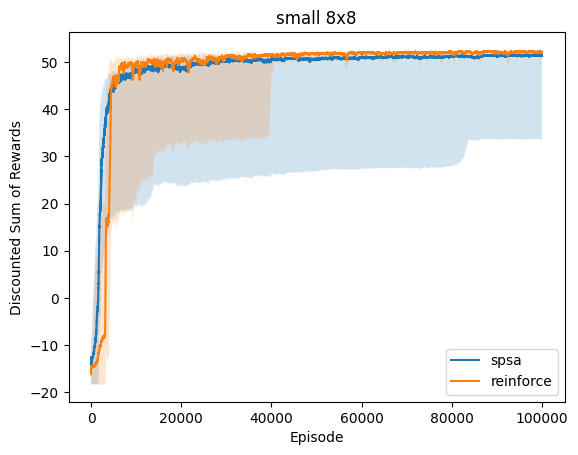

spsa medium


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
8,"[-0.09, -0.25, -0.26, -0.38, 1.2, -0.98]","[0.44, -0.45, 0.42, -0.71, 1.03, 1.06]","[-0.79, 0.07, 0.44, 1.14, 0.92, -0.7]","[-1.31, -0.67, -0.51, 0.57, 0.34, -0.27]",0.32,0.15,0.51,-0.34,78.228966
1,"[0.06, -0.08, -0.09, -0.94, -0.06, -0.23]","[-0.15, 1.4, 0.15, -0.37, 0.56, 0.0]","[0.67, -0.65, -0.36, 1.1, -0.48, 0.53]","[0.02, -0.24, 0.08, -0.59, -0.11, -0.22]",0.25,0.74,-0.01,-0.29,78.181710
4,"[-1.08, -0.28, -1.1, -0.01, -0.96, -0.01]","[0.34, 0.81, 0.53, 0.43, -0.13, -0.63]","[1.66, -1.42, -0.27, 1.15, 0.33, 0.44]","[-0.94, -0.18, -0.28, -1.38, 0.35, -0.09]",0.04,-0.35,0.01,0.13,77.703848
0,"[-0.65, 0.17, -0.05, -0.42, -0.39, -0.59]","[1.45, 1.0, -0.66, -0.82, -0.24, 0.5]","[0.37, -0.61, -0.07, 1.03, 0.27, 0.51]","[0.0, 0.0, -0.81, -0.18, -0.33, 0.31]",-0.61,0.25,-0.89,0.03,77.651079
9,"[0.01, -0.73, -0.21, 0.39, 0.1, -0.25]","[0.25, 0.71, -0.19, -0.08, 0.29, 0.53]","[0.09, -0.02, -0.04, 1.27, 0.52, -0.0]","[-0.82, 0.22, -0.38, 0.13, 0.37, -0.35]",0.33,-0.41,0.52,-0.15,77.568669
5,"[-0.25, -0.7, 0.96, 0.48, 0.61, 0.14]","[-0.29, 1.49, -1.15, 0.14, -0.24, -0.44]","[-0.54, -0.46, 0.28, 0.84, 1.03, 0.41]","[-0.28, -0.19, -0.43, -0.44, 0.35, -0.8]",0.23,-0.97,0.19,0.41,76.941912
6,"[-0.58, 0.22, 0.93, 0.27, -0.15, -0.75]","[-0.17, -0.0, -0.48, -0.93, 0.18, 0.92]","[0.02, -0.56, -0.81, 0.33, 0.89, 0.4]","[-0.94, -0.26, -0.42, 0.34, -0.06, -0.46]",0.00,-0.37,0.30,0.46,76.778277
3,"[-0.83, -0.11, -0.22, 0.02, -0.34, -0.72]","[0.55, 0.66, 0.41, -0.37, 0.09, 1.02]","[0.02, -0.17, 0.59, 1.06, -0.0, 0.53]","[0.01, 0.18, 0.2, 0.8, 0.85, -0.01]",0.42,-0.27,-0.88,-0.29,75.434856
2,"[0.15, -0.05, -0.02, -0.1, 0.34, -0.08]","[-0.1, -0.41, 0.16, -0.31, -0.07, 0.19]","[-0.09, 0.45, 0.28, -0.05, 0.3, 0.24]","[-0.16, 0.22, -0.2, 0.09, -0.1, 0.03]",0.02,0.06,0.13,-0.25,-10.118193
7,"[0.12, -0.3, 0.17, 0.09, -0.3, -0.2]","[-0.25, 0.11, -0.06, 0.38, 0.36, 0.26]","[-0.18, -0.12, 0.02, -0.06, 0.14, -0.32]","[0.4, -0.41, 0.19, -0.02, 0.31, -0.09]",-0.10,0.12,0.38,0.06,-10.340505


reinforce medium


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
7,"[-6.45, -6.68, -0.16, -0.11, -0.59, -0.52]","[-0.2, 0.16, -0.22, 0.16, 0.22, 0.06]","[0.11, -0.0, 0.38, 0.25, 0.61, 0.02]","[-0.09, -0.76, -0.02, -0.39, -0.26, -0.32]",-0.42,-0.06,1.06,-0.49,78.908829
5,"[-2.06, -2.63, 0.01, -0.14, 0.09, -0.57]","[-0.19, 0.37, -0.46, 0.24, -0.04, 0.14]","[-0.28, 0.11, 0.37, 0.29, 0.61, 0.2]","[-6.67, -5.98, -0.51, -0.87, -0.88, -0.61]",-0.37,-0.32,0.51,-0.65,78.825448
6,"[-0.28, -0.27, 0.04, -0.14, -0.6, -0.33]","[0.28, 0.31, 0.26, -0.12, 0.03, 0.12]","[0.08, 0.2, -0.27, 0.2, 0.4, 0.06]","[-0.68, -0.72, -0.93, -0.81, -0.6, -0.26]",-0.55,0.33,-0.13,-0.45,78.810152
3,"[-8.49, -8.4, -0.35, -0.63, -0.14, -0.49]","[0.21, 0.22, -0.15, 0.07, -0.17, 0.22]","[-0.27, -0.1, -0.14, 0.2, -0.11, 0.39]","[-7.1, -7.08, -0.21, -0.59, 0.05, -0.79]",-0.72,-0.34,0.23,-0.63,78.708376
4,"[-5.83, -5.88, -0.67, -0.63, -0.73, -0.84]","[0.37, 0.35, -0.0, 0.28, -0.19, -0.28]","[0.44, 0.01, 0.2, 0.36, 0.37, -0.13]","[-0.65, -0.87, -0.42, -0.58, -0.34, -0.5]",-0.11,-0.00,0.55,-0.32,78.696109
1,"[-3.35, -3.75, -0.49, -0.27, -0.8, -0.4]","[-0.06, 0.29, 0.12, -0.03, 0.05, 0.08]","[0.33, -0.05, 0.09, 0.11, 0.3, 0.17]","[-7.21, -7.46, -0.67, -0.8, -0.58, -0.76]",-0.89,0.09,0.58,-0.11,78.687148
2,"[-0.51, -0.65, -0.16, -0.31, 0.02, -0.28]","[0.2, -0.02, 0.29, -0.17, 0.18, 0.29]","[-0.06, 0.34, 0.06, 0.23, 0.21, -0.22]","[-5.26, -4.73, -1.12, -0.79, -0.59, -0.46]",-0.61,0.45,0.06,-0.56,78.658592
8,"[-1.19, -0.99, -0.12, -0.59, -0.47, -0.4]","[0.45, -0.3, 0.24, -0.16, 0.53, 0.28]","[-0.18, -0.19, -0.37, 0.39, 0.27, -0.15]","[-2.3, -2.54, -0.79, -0.51, -0.8, -0.41]",-0.48,-0.08,0.19,-0.61,78.392582
9,"[-0.44, -0.72, -0.13, 0.17, -0.07, -0.07]","[-0.06, 0.46, 0.14, 0.07, 0.65, 0.24]","[0.0, 0.11, 0.3, 0.32, 0.19, 0.23]","[-0.07, -0.04, -0.61, -0.58, -0.05, 0.06]",-0.65,0.04,0.70,-0.40,77.096466
0,"[-7.68, -7.51, -0.5, -0.52, -0.31, -0.38]","[0.02, 0.38, -0.06, 0.04, -0.1, -0.06]","[-0.28, -0.17, 0.0, 0.23, 0.31, 0.36]","[-0.86, -0.72, -0.27, -0.06, -0.61, -0.18]",-0.64,0.04,0.77,-0.85,62.207477


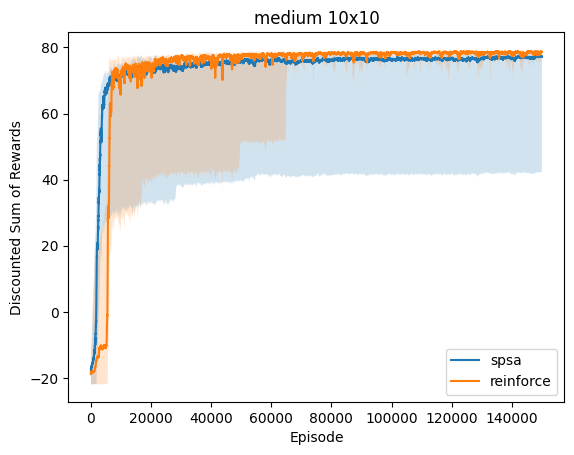

spsa medium20


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[0.13, 1.12, 0.07, -1.35, -0.6, -0.25]","[0.77, 0.59, 1.46, -1.38, 0.21, 0.76]","[0.9, -0.32, -0.59, 1.04, -0.74, -0.47]","[0.31, -0.36, 1.06, -1.27, -0.49, -0.76]",-0.05,0.89,1.19,-0.87,238.891890
5,"[0.15, -0.91, 0.2, -0.11, -0.65, -0.86]","[-0.9, 0.93, -0.11, -0.23, 0.34, 0.21]","[-0.51, -0.94, -0.12, 1.46, 0.27, 0.34]","[-1.15, 0.08, 0.45, 0.27, -0.62, -0.37]",0.40,-0.79,-0.60,-0.02,238.138515
3,"[-1.68, 0.15, 0.58, -0.81, -1.11, -0.44]","[0.82, 1.54, 0.4, -0.13, 1.02, -0.19]","[-0.97, 0.21, 0.28, 0.96, 0.23, 0.16]","[0.74, 0.32, 0.25, -0.05, 2.11, -0.63]",-0.98,-1.04,0.25,-0.29,231.870040
6,"[-0.5, -0.93, 0.43, -0.53, -0.31, -1.01]","[-0.14, 0.92, -0.28, -0.05, -0.31, -0.0]","[0.39, -0.08, -0.31, 1.5, 0.83, -0.44]","[-0.58, 0.2, 0.63, 0.16, -0.08, -0.77]",0.35,0.39,0.18,1.23,223.604388
8,"[-0.13, 0.17, 0.54, -0.64, 0.1, -0.22]","[0.6, 0.05, -0.14, 0.06, -0.76, 0.21]","[-0.27, -0.68, -1.25, 1.27, 0.66, -0.14]","[-0.49, -1.33, 0.08, -0.12, -0.7, -0.59]",0.30,0.21,-0.07,0.03,218.791653
4,"[-0.91, 0.11, -0.06, -1.15, -0.12, 0.03]","[0.03, 0.85, -0.47, -0.97, -0.86, 0.52]","[1.21, 0.1, 0.43, 0.56, 0.89, -0.26]","[-0.43, -0.68, -0.97, -0.92, -0.45, -0.51]",0.42,-0.61,-0.26,1.11,215.363560
1,"[0.25, -0.2, -0.25, 0.14, -0.28, -0.31]","[-0.67, 1.01, 0.32, -0.95, 0.17, 0.43]","[-0.43, -0.03, -0.29, 0.91, 0.81, -0.3]","[0.09, 0.46, -0.22, -0.39, 0.15, 0.12]",-0.07,-0.19,-0.36,0.51,214.502164
7,"[0.06, -0.28, -0.01, 0.12, -0.23, -0.06]","[-0.19, 0.16, -0.15, 0.31, 0.27, 0.22]","[-0.11, -0.23, -0.09, -0.09, 0.18, -0.27]","[0.31, -0.36, 0.32, -0.05, 0.24, -0.04]",0.09,0.10,0.38,0.07,-15.877278
2,"[0.13, -0.1, 0.04, 0.1, 0.28, 0.19]","[-0.12, -0.18, 0.08, -0.37, 0.02, 0.08]","[-0.01, 0.36, 0.16, 0.22, 0.03, -0.3]","[-0.24, 0.34, -0.44, -0.08, 0.02, 0.17]",0.01,0.17,0.01,-0.18,-27.498500
9,"[-0.02, -0.18, -0.09, 0.12, 0.4, 0.25]","[-0.24, 0.4, -0.13, -0.12, 0.27, 0.06]","[-0.26, -0.23, 0.03, -0.11, 0.12, -0.22]","[-0.03, 0.12, 0.09, 0.28, 0.34, 0.32]",0.07,-0.35,0.34,0.13,-28.386566


reinforce medium20


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[-0.03, 0.18, -0.34, -0.31, -0.14, 0.08]","[0.13, 0.47, -0.04, 0.1, -0.09, -0.08]","[-0.24, -0.11, -0.04, 0.16, 0.17, 0.4]","[-0.31, -0.17, 0.15, 0.34, -0.08, 0.27]",-0.10,0.03,0.49,-0.43,243.803837
3,"[-0.73, -0.65, -0.22, -0.42, -0.08, -0.4]","[0.19, 0.18, -0.11, 0.14, -0.13, 0.21]","[-0.22, -0.03, -0.18, 0.15, -0.16, 0.43]","[0.84, 0.87, 0.06, -0.28, 0.33, -0.49]",-0.34,-0.41,0.05,0.01,231.834603
8,"[-0.04, 0.16, 0.27, -0.25, -0.07, 0.0]","[0.47, -0.24, 0.22, -0.15, 0.45, 0.29]","[-0.23, -0.29, -0.38, 0.35, 0.28, -0.18]","[-0.07, -0.31, -0.36, -0.07, -0.41, 0.01]",0.11,-0.19,-0.05,-0.11,37.288422
4,"[0.07, 0.08, -0.31, -0.2, -0.39, -0.35]","[0.45, 0.35, 0.33, 0.51, 0.01, -0.18]","[0.44, 0.1, -0.02, 0.21, 0.19, -0.15]","[-0.24, -0.43, -0.18, -0.32, -0.03, -0.07]",0.28,0.30,0.16,-0.03,-15.399554
7,"[0.06, -0.21, 0.11, 0.1, -0.18, -0.04]","[-0.16, 0.17, 0.09, 0.41, 0.41, 0.13]","[-0.01, -0.08, -0.16, -0.18, 0.04, -0.45]","[0.3, -0.38, 0.15, -0.18, 0.13, 0.07]",-0.01,0.28,0.20,-0.00,-15.691751
5,"[0.6, 0.03, 0.33, 0.27, 0.32, -0.3]","[-0.16, 0.3, -0.12, 0.55, 0.28, 0.18]","[-0.37, 0.12, 0.03, -0.07, 0.33, 0.1]","[-0.43, 0.28, -0.03, -0.34, -0.42, 0.16]",0.35,-0.05,-0.06,0.06,-15.916475
6,"[0.07, 0.05, 0.4, 0.1, -0.26, -0.04]","[0.15, 0.21, 0.1, -0.22, -0.1, -0.01]","[0.2, 0.3, -0.21, 0.24, 0.35, 0.18]","[-0.2, -0.28, -0.34, -0.24, -0.13, 0.18]",0.04,-0.06,-0.15,0.20,-15.993572
1,"[0.25, -0.14, -0.12, 0.12, -0.38, 0.24]","[-0.14, 0.15, 0.16, 0.07, 0.2, 0.05]","[0.2, -0.11, -0.1, -0.09, -0.01, -0.02]","[0.41, 0.18, -0.21, -0.29, -0.13, -0.23]",-0.12,0.09,0.18,0.20,-23.007923
2,"[0.09, -0.11, 0.17, 0.05, 0.2, 0.1]","[-0.05, -0.34, 0.08, -0.36, 0.03, 0.02]","[0.01, 0.44, -0.03, 0.09, 0.18, -0.3]","[-0.14, 0.41, -0.4, -0.04, -0.04, 0.31]",-0.02,0.10,-0.02,-0.24,-27.885083
9,"[0.1, -0.19, 0.01, 0.25, 0.36, 0.33]","[-0.14, 0.43, -0.1, -0.07, 0.35, 0.1]","[-0.12, -0.07, -0.06, -0.08, -0.05, -0.19]","[-0.02, 0.13, 0.18, 0.27, 0.37, 0.22]",0.02,-0.34,0.25,0.25,-29.118276


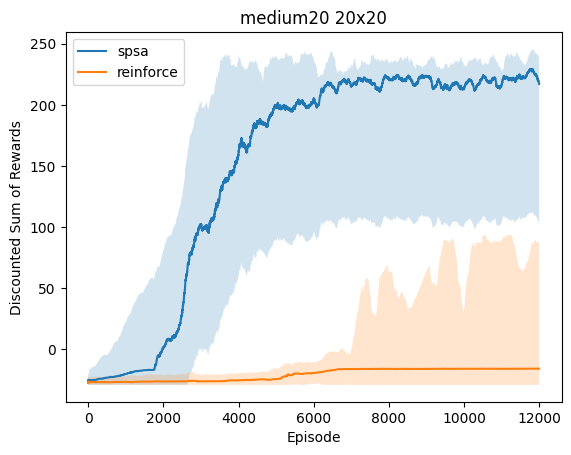

spsa large


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
4,"[7.98, 0.16, -5.81, -1.18, -0.53, -6.22]","[2.23, 8.34, -0.95, 3.02, -1.01, 0.05]","[0.96, 2.41, -0.06, 12.04, 0.64, -2.9]","[3.79, -7.66, -8.41, 1.85, 4.11, -2.08]",1.45,8.53,13.15,-0.70,829.972781
8,"[-2.37, 4.2, 5.59, 2.54, 5.16, -11.65]","[21.35, 5.62, -3.33, -10.14, -4.94, 6.29]","[3.43, -0.84, 5.49, 5.88, -5.77, -2.21]","[-3.87, -0.12, 4.64, -4.25, -1.47, -6.73]",-4.48,0.07,-6.90,-7.96,813.793470
5,"[0.15, 2.71, 1.61, -0.12, -2.78, -0.75]","[-8.34, 9.83, 1.05, -0.26, 2.79, -0.27]","[-9.92, 2.03, 0.43, 2.25, -2.01, 4.82]","[-4.8, -2.03, -0.83, 4.37, 3.56, 0.47]",-2.61,-7.16,-1.62,-2.09,782.946760
0,"[-0.2, 4.37, 3.01, -14.11, -0.94, -5.25]","[-3.17, 9.82, 4.81, -6.6, 1.39, 2.46]","[-6.93, -1.58, 3.21, 6.7, -4.64, 0.24]","[-5.64, 6.43, 1.37, -4.51, 3.65, -5.12]",-8.30,-3.25,5.72,-0.97,765.317882
3,"[2.47, -3.75, 3.23, -4.58, -7.43, -8.78]","[1.66, 1.64, -2.23, -5.08, -0.68, 4.43]","[1.21, -3.26, -6.75, 3.93, -0.41, 0.92]","[-3.0, 6.3, -3.76, -3.43, -7.15, -6.41]",3.45,3.93,7.71,7.12,688.703120
1,"[-0.04, 0.18, -0.08, -0.3, -0.39, 0.18]","[0.01, 0.49, 0.39, 0.63, 0.04, 0.33]","[-0.04, -0.27, -0.16, 0.23, 0.35, 0.02]","[0.37, -0.02, -0.27, -0.64, -0.07, -0.32]",-0.09,0.33,0.30,0.15,-21.046756
2,"[0.08, -0.29, 0.32, 0.24, 0.23, 0.07]","[-0.24, -0.39, -0.14, -0.48, -0.2, -0.19]","[-0.09, 0.63, 0.19, 0.31, 0.3, 0.39]","[-0.22, 0.33, -0.45, -0.01, 0.04, 0.06]",0.09,-0.25,-0.04,-0.25,-21.157432
7,"[0.11, -0.45, 0.39, -0.15, -0.35, -0.1]","[-0.31, 0.19, -0.45, 0.36, 0.21, 0.16]","[-0.38, -0.39, -0.23, -0.09, 0.12, -0.28]","[0.15, -0.65, 0.35, -0.09, 0.11, -0.06]",-0.22,0.09,0.20,-0.08,-21.245707
6,"[0.17, 0.03, 0.39, 0.14, -0.44, 0.12]","[0.05, 0.01, 0.11, -0.24, -0.21, 0.02]","[0.31, 0.12, -0.36, 0.41, 0.13, 0.4]","[-0.11, -0.07, -0.33, -0.36, -0.1, 0.02]",0.16,-0.09,-0.17,0.51,-21.266969
9,"[0.11, -0.13, 0.39, 0.56, 0.22, 0.65]","[-0.12, 1.08, -0.35, 0.02, 0.18, -0.2]","[-0.25, -0.28, -0.43, -0.09, -0.01, 0.18]","[-0.17, -0.29, -0.45, 0.2, 0.11, 0.11]",-0.36,0.03,0.08,0.07,-33.095503


reinforce large


,fc.weight.up,fc.weight.right,fc.weight.down,fc.weight.left,fc.bias.up,fc.bias.right,fc.bias.down,fc.bias.left,perf
0,"[0.31, 0.29, -0.25, -0.11, -0.15, 0.33]","[1.97, 1.32, -0.23, -0.03, -0.3, -0.21]","[-0.02, 0.07, 0.06, 0.18, 0.5, 0.61]","[-0.3, -0.11, 0.12, 0.37, -0.27, 0.27]",-0.18,-0.04,0.68,-0.55,2.409756
3,"[-0.4, -0.32, -0.29, -0.4, -0.11, -0.47]","[0.21, 0.14, 0.09, 0.34, 0.03, 0.25]","[-0.28, -0.03, -0.2, -0.01, 0.02, 0.38]","[0.28, 0.31, -0.17, -0.35, 0.03, -0.69]",-0.39,-0.21,0.30,-0.39,-14.312385
8,"[-0.03, 0.18, -0.06, -0.43, -0.43, -0.28]","[0.51, -0.23, 0.23, -0.15, 0.5, 0.33]","[-0.26, -0.34, -0.42, 0.3, 0.39, -0.22]","[-0.1, -0.33, -0.47, -0.17, -0.42, -0.16]",-0.27,-0.03,0.28,-0.63,-16.765111
7,"[0.65, 0.35, -0.06, 0.01, -0.27, 0.14]","[-0.1, 0.11, 0.5, 0.7, 0.78, 0.21]","[5.17, 4.35, -0.03, 0.03, 0.15, -0.3]","[0.44, -0.07, -0.13, -0.32, -0.1, 0.2]",-0.19,1.01,-0.27,-0.26,-20.975033
6,"[2.21, 0.85, 0.11, -0.02, -0.46, -0.19]","[1.15, 0.72, 0.14, -0.2, 0.07, -0.0]","[0.37, 0.49, -0.08, 0.34, 0.57, 0.33]","[-0.08, -0.02, -0.55, -0.37, -0.44, 0.3]",-0.52,0.19,0.35,-0.38,-20.988086
9,"[0.66, 0.38, -0.04, 0.24, 0.25, 0.28]","[1.34, 1.92, -0.04, 0.0, 0.5, 0.31]","[6.89, 6.92, 0.39, 0.35, 0.29, 0.18]","[2.12, 2.27, -0.12, 0.13, 0.16, 0.26]",-0.18,-0.36,0.79,-0.09,-21.000904
4,"[3.8, 3.33, -0.3, -0.08, -0.45, -0.19]","[0.62, 0.5, 0.3, 0.49, 0.2, 0.03]","[3.81, 3.42, 0.2, 0.38, 0.22, -0.26]","[-0.12, -0.22, -0.58, -0.66, -0.31, 0.02]",0.09,0.53,0.22,-0.29,-21.001274
5,"[5.36, 3.83, 0.17, 0.23, -0.01, -0.5]","[-0.06, 0.28, 0.17, 0.69, 0.73, 0.34]","[-0.12, 0.4, 0.08, -0.03, 0.46, 0.3]","[-0.27, 0.58, -0.27, -0.41, -0.67, 0.3]",-0.01,0.55,-0.03,-0.30,-21.045694
1,"[0.74, 0.33, -0.32, 0.03, -0.4, 0.32]","[1.22, 1.64, 0.39, 0.18, 0.51, 0.28]","[3.85, 3.46, -0.01, 0.03, -0.03, 0.11]","[6.55, 6.29, -0.34, -0.24, -0.38, -0.19]",-0.40,0.51,0.34,-0.19,-21.061271
2,"[1.72, 1.4, 0.15, 0.08, 0.18, 0.03]","[3.02, 1.5, -0.17, -0.58, -0.08, -0.15]","[1.49, 1.9, 0.14, 0.24, 0.22, -0.15]","[-0.91, 0.23, -0.31, 0.03, 0.11, 0.44]",-0.17,0.22,0.05,-0.23,-33.182503


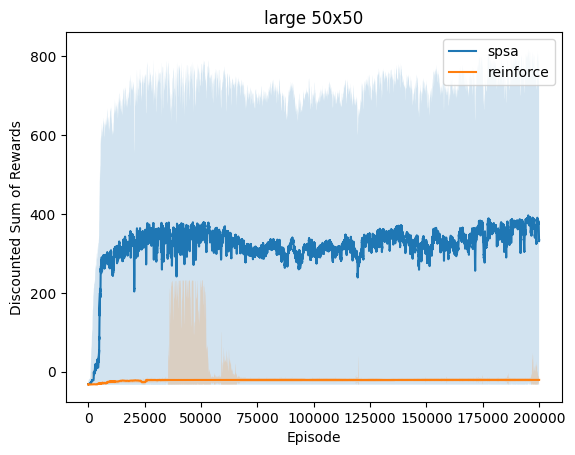

In [7]:
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
for grid, gridsize in zip("tiny small medium medium20 large".split(), gridsizes):
    for algo in "spsa reinforce".split():
        dirname = os.path.join("saves", algo, grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        print(algo, grid)
        avg_rewards, bot, top = get_results(path)
        plt.plot(avg_rewards, label=algo)
        plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)
    plt.title(f"{grid} {gridsize}")
    plt.xlabel('Episode')
    plt.ylabel('Discounted Sum of Rewards')
    plt.legend()
    plt.show()
